In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime
import networkx as nx
import math
from collections import Counter, OrderedDict
from scipy.stats import shapiro
from scipy.stats import ks_2samp
import scipy.stats as stats
from scipy.stats import lognorm
import statsmodels.api as sm
from scipy.stats import norm
import pylab
from scipy.stats import yeojohnson
from scipy.stats import anderson

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/tweetsConvereted2017_toxicPerspectiveScore.csv")

In [ ]:
G = nx.read_edgelist('/content/gdrive/My Drive/users.edgelist')

In [ ]:
groupDf = df[['user_id', 'Toxicity']]
groupDf2 = groupDf[['user_id', 'Toxicity']].astype({'user_id': str})
groupedDf = groupDf2.groupby(['user_id']).agg({'Toxicity': 'mean'}).reset_index()

In [ ]:
users_list = list(groupedDf['user_id'].unique().astype(str))
G2 = G.subgraph(users_list)

In [ ]:
user_toxicity = groupedDf.set_index('user_id')['Toxicity'].to_dict()

In [ ]:
neighbor_toxicity = {}
for user in G2.nodes():
  neighbors = list(G2.neighbors(user))
  if user in neighbors:
      neighbors.remove(user)
  if len(neighbors) > 0:
      neighbor_toxicity[user] = groupedDf[groupedDf['user_id'].isin(neighbors)]['Toxicity'].mean()

In [ ]:
x = [user_toxicity[user] for user in neighbor_toxicity.keys()]
y = list(neighbor_toxicity.values())

In [ ]:
diff = [x[i] - y[i] for i in range(len(x))]

In [ ]:
diff2 = diff[:]
diff3 = diff[:]
diff4 = diff[:]
diff5 = diff[:]

In [ ]:
if sorted(diff) == sorted(diff2):
    print("The lists are the same")
else:
    print("The lists are not the same")

The lists are the same


In [ ]:
diff = [elem * 10 for elem in diff]
diff = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff]
diff = [elem / 10 for elem in diff]

In [ ]:
diff_counts = Counter(diff)
sorted_counts = OrderedDict(sorted(diff_counts.items()))

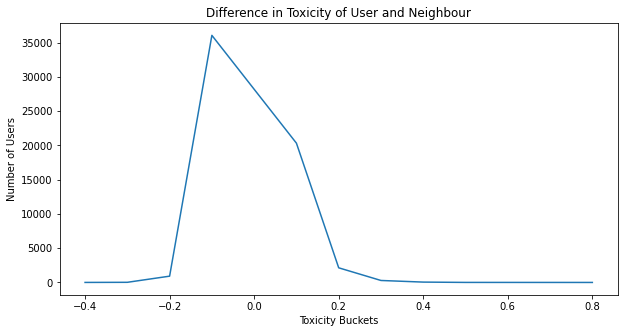

In [ ]:
values = list(sorted_counts.keys())
counts = list(sorted_counts.values())

plt.figure(figsize=(10,5))
plt.plot(values, counts)
plt.xlabel('Toxicity Buckets')
plt.ylabel('Number of Users')
plt.title('Difference in Toxicity of User and Neighbour')
plt.show()

In [ ]:
stat, p = shapiro(diff)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7124117612838745
p-value: 0.0
The sample is not normally distributed


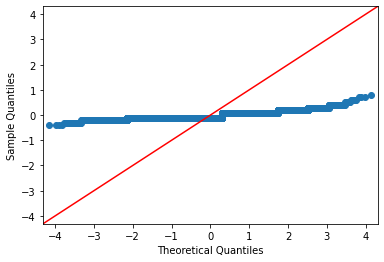

In [ ]:
diff_qq = np.array(diff)
sm.qqplot(diff_qq, line='45')
pylab.show()

In [ ]:
#box cox
shifted_diff = np.array(diff) - min(diff) + 1e-8
diff_boxcox, lambda_diff = stats.boxcox(shifted_diff)
print(lambda_diff)

0.22359171756190935


In [ ]:
#yeo johnson
transformed_data, lambda_ = yeojohnson(diff)
print(lambda_)

-3.7875952581327543


In [ ]:
#log transformation
shifted_diff_log = np.array(diff) - min(diff) + 1e-8
log_diff = np.log(shifted_diff_log)

In [ ]:
#square root transformation
shifted_diff_sqrt = np.array(diff) - min(diff) + 1e-8
diff_sqrt = np.sqrt(shifted_diff_sqrt)

In [ ]:
# Exponential Transformation
diff_exp = np.exp(diff)

In [ ]:
stat, p = shapiro(diff_exp)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7086309194564819
p-value: 0.0
The sample is not normally distributed


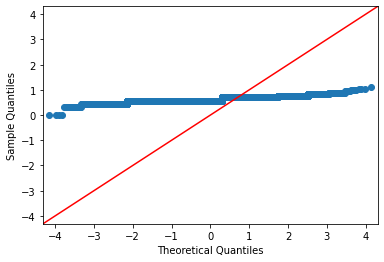

In [ ]:
diff_qq_2 = np.array(diff_sqrt)
sm.qqplot(diff_qq_2, line='45')
pylab.show()

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/

#0.1 bucket

In [ ]:
diff_counts = Counter(diff)
sorted_counts = OrderedDict(sorted(diff_counts.items()))

In [ ]:
len(sorted_counts)

12

In [ ]:
stat, p = shapiro(diff)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7124117612838745
p-value: 0.0
The sample is not normally distributed


In [ ]:
shifted_diff = np.array(diff) - min(diff) + 1e-8
diff_boxcox, lambda_diff = stats.boxcox(shifted_diff)
print(lambda_diff)

0.22359171756190935


In [ ]:
stat, p = shapiro(diff_boxcox)

print("diff")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff
Shapiro-Wilk test statistic: 0.7102301716804504
p-value: 0.0
The sample is not normally distributed


#0.01 Bucket


In [ ]:
diff2 = [elem * 100 for elem in diff2]
diff2 = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff2]
diff2 = [elem / 100 for elem in diff2]

In [ ]:
diff2_counts = Counter(diff2)
sorted_counts2 = OrderedDict(sorted(diff2_counts.items()))

In [ ]:
len(sorted_counts2)

84

In [ ]:
stat, p = shapiro(diff2)

print("diff2")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff2
Shapiro-Wilk test statistic: 0.9085466265678406
p-value: 0.0
The sample is not normally distributed


In [ ]:
shifted_diff2 = np.array(diff2) - min(diff2) + 1e-8
diff2_boxcox, lambda_diff2 = stats.boxcox(shifted_diff2)
print(lambda_diff2)

0.2957655704982542


In [ ]:
stat, p = shapiro(diff2_boxcox)

print("diff2")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff2
Shapiro-Wilk test statistic: 0.9354462027549744
p-value: 0.0
The sample is not normally distributed


#0.001 Bucket

In [ ]:
diff3 = [elem * 1000 for elem in diff3]
diff3 = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff3]
diff3 = [elem / 1000 for elem in diff3]

In [ ]:
diff3_counts = Counter(diff3)
sorted_counts3 = OrderedDict(sorted(diff3_counts.items()))

In [ ]:
len(sorted_counts3)

554

In [ ]:
stat, p = shapiro(diff3)

print("diff3")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff3
Shapiro-Wilk test statistic: 0.8963183164596558
p-value: 0.0
The sample is not normally distributed


In [ ]:
shifted_diff3 = np.array(diff3) - min(diff3) + 1e-8
diff3_boxcox, lambda_diff3 = stats.boxcox(shifted_diff3)
print(lambda_diff3)

0.3021423054357786


In [ ]:
stat, p = shapiro(diff3_boxcox)

print("diff2")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff2
Shapiro-Wilk test statistic: 0.9247919917106628
p-value: 0.0
The sample is not normally distributed


#0.0001 bucket

In [ ]:
diff4 = [elem * 10000 for elem in diff4]
diff4 = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff4]
diff4 = [elem / 10000 for elem in diff4]

In [ ]:
diff4_counts = Counter(diff4)
sorted_counts4 = OrderedDict(sorted(diff4_counts.items()))

In [ ]:
len(sorted_counts4)

3592

In [ ]:
stat, p = shapiro(diff4)

print("diff4")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff4
Shapiro-Wilk test statistic: 0.8943188190460205
p-value: 0.0
The sample is not normally distributed


In [110]:
stat,crtical,signifi = anderson(diff4)
print(stat)
print(crtical)
print(signifi)

1558.7243414649347
[0.576 0.656 0.787 0.918 1.092]
[15.  10.   5.   2.5  1. ]


In [113]:
data = np.random.randint(0, 10, size=100)
stat,crtical,signifi = anderson(data)
print(stat)
print(crtical)
print(signifi)

2.9639889461573716
[0.555 0.632 0.759 0.885 1.053]
[15.  10.   5.   2.5  1. ]


In [ ]:
shifted_diff4 = np.array(diff4) - min(diff4) + 1e-8
diff4_boxcox, lambda_diff4 = stats.boxcox(shifted_diff4)
print(lambda_diff4)

0.30339968585616267


In [ ]:
stat, p = shapiro(diff4_boxcox)

print("diff4")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff4
Shapiro-Wilk test statistic: 0.9230678081512451
p-value: 0.0
The sample is not normally distributed


#0.00001 Bucket

In [ ]:
diff5 = [elem * 100000 for elem in diff5]
diff5 = [math.ceil(elem) if elem >= 0 else math.floor(elem) for elem in diff5]
diff5 = [elem / 100000 for elem in diff5]

In [ ]:
diff5_counts = Counter(diff5)
sorted_counts5 = OrderedDict(sorted(diff5_counts.items()))

In [ ]:
diff5_counts = Counter(diff5)
sorted_counts5 = OrderedDict(sorted(diff5_counts.items()))

In [ ]:
stat, p = shapiro(diff5)

print("diff5")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff5
Shapiro-Wilk test statistic: 0.894142746925354
p-value: 0.0
The sample is not normally distributed


In [ ]:
shifted_diff5 = np.array(diff5) - min(diff5) + 1e-8
diff5_boxcox, lambda_diff5 = stats.boxcox(shifted_diff5)
print(lambda_diff5)

0.3035080722908256


In [ ]:
stat, p = shapiro(diff5_boxcox)

print("diff5")
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("The sample is normally distributed")
else:
    print("The sample is not normally distributed")

diff5
Shapiro-Wilk test statistic: 0.9228550791740417
p-value: 0.0
The sample is not normally distributed
